# Морфология 2
В данном ноутбуке находится задание на триграммы и словарь. В качестве текста будем использовать томик войны и мира: https://goo.gl/qcVTLE 

Для начала напомним некоторые полезные инструменты на питоне

## 1. Инструменты

### 1.1. Регулярные выражения
Исчерпывающий пост https://habr.com/ru/post/349860/

In [1]:
import re

# С помощью рег. выражения можно искать, заменять и сентезировать строки по шаблонам
# Парочка простых примеров
numbers = re.findall(r'\d+', r'There is some numbers: 49 and 432')
print (u'Находим числа в строке: ', numbers)

print (u'Простенький токенизатор: ', re.sub('[,\.?!]',' ','How, to? split. text!').split())

print (u'Еще один токенизатор: ', re.split(r'\W+', 'How, to? split. text! Again'))

# в качестве тренировки придумайте свой токенизатор в случае, когда из текста нужно получить только русские слова.
print (u'Токенизатор для русских слов: ', re.sub('[^а-яА-Яё]', ' ', 'How, to? split. text! Работает Again ли ёж?').split())

Находим числа в строке:  ['49', '432']
Простенький токенизатор:  ['How', 'to', 'split', 'text']
Еще один токенизатор:  ['How', 'to', 'split', 'text', 'Again']
Токенизатор для русских слов:  ['Работает', 'ли', 'ёж']


### 1.2. Чтение файлов
Чтобы не мучится самим с кодировками, приведем способ чтения файла корпуса.

In [2]:
import io
wordlist = None
text_file_path = './wp.txt'
with io.open(text_file_path, "r") as text_file:
    text = text_file.read()
    #Здесь заиспользуем токенизатор. Также приведем все слова к нижнему регистру.
    wordlist = re.sub('[^а-яА-Яё]', ' ', text.lower()).split()

### 1.3. ООП
В питоне можно создавать свои классы, скорее всего нам понадобится класс для хранения бора

In [3]:
class Node:
    def __init__(self):
        '''
        Simple constructor without params
        '''
        pass
    
    def method(self, par):
        '''
        Simple method with one param
        '''
        pass
    
# все данные хранятся в self, поэтому он и передается первым аргументом во все методы

### 1.4. pyplot
Довольно часто приходится построить какие-нибудт графики и гистограммы для изучения данных, с которыми придется работать. Для этого в питоне есть удобнейший модуль для этого - pyplot. Туториал: https://matplotlib.org/3.1.1/tutorials/introductory/pyplot.html

In [4]:
#!pip install matplotlib # Установка модуля
import matplotlib.pyplot as plt
# команда чтобы картинки рисовались прямо в ноутбуке
%matplotlib inline 

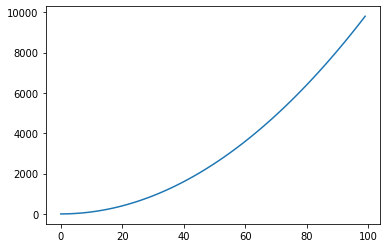

In [5]:
# Посмотрим на график функции x^2
data = [i * i for i in range(100)]
plt.plot(data)

(array([32., 13., 10.,  8.,  8.,  6.,  6.,  6.,  5.,  6.]),
 array([   0. ,  980.1, 1960.2, 2940.3, 3920.4, 4900.5, 5880.6, 6860.7,
        7840.8, 8820.9, 9801. ]),
 <a list of 10 Patch objects>)

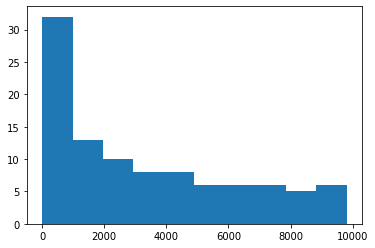

In [6]:
# и распределение по значениям
plt.hist(data)

Также полезная команда для подсчета времения выполнеия в ячейке

In [7]:
%%time
res = 0
for i in range(int(1e8)):
    res += 1

CPU times: user 10.2 s, sys: 25.4 ms, total: 10.3 s
Wall time: 10.3 s


## 2. Задание
Собственно теперь нам потребуется написать подсчет триграмм и бор для словаря, чтобы реализовать простенькую систему исправления ошибок.

### 2.1. Триграммы
Для начала получим словарь триграмма - её кол-во в тексте, не забывая о начале и конце слова.

Далее можно построить гистограмму на кол-во вхождений триграмм, и посмотреть самые частые и какая частота у каких-нибудь заведомо странных, например: 'чгк', 'шкя' и подобные. Из полученных данных придумать эвристику, как считать слово с опечаткой. Проверить эвристику по словарю.

In [37]:
from nltk import ngrams
from collections import Counter

n_grams = 3

def corpus_trigrams(word_list):
    '''returns trigrams count dictionary'''
    trigrams_counter = Counter()
    for word in word_list:
        word_trigrams = get_word_ngrams(word)
        for trigram in word_trigrams:
            trigrams_counter[trigram] += 1
    return trigrams_counter

def frequency_trigrams(word_list):
    '''returns trigrams frequency dictionary'''
    trigrams_dict = corpus_trigrams(word_list)
    trigrams_count = sum(trigrams_dict.values())
    return {trigram : (count / trigrams_count) for trigram, count in trigrams_dict.most_common()}



def is_error(word, trigrams_dict, bound):
    '''is the word with mistake'''
    for trigram in get_word_ngrams(word):
        if not trigram in trigrams_dict.keys() or trigrams_dict[trigram] < bound:
            return True
    return False

def get_word_ngrams(word):
    word = '##' + word + '##'
    word_trigrams = ngrams(word, n_grams)
    return [''.join(trigram) for trigram in word_trigrams]

In [38]:
trigrams_dict = corpus_trigrams(wordlist)
print('чгк:',trigrams_dict.get('чгк', 0), '; шкя:', trigrams_dict.get('шкя', 0))

чгк: 0 ; шкя: 0


In [39]:
# trigrams_frequency = frequency_trigrams(wordlist)
print(is_error("корова", trigrams_dict, 100))
print(is_error("карова", trigrams_dict, 100))
print('')
print(is_error("корова", trigrams_dict, 100))
print(is_error("корава", trigrams_dict, 100))
print('')
print(is_error("стол", trigrams_dict, 10))
print(is_error("стул", trigrams_dict, 10))
print(is_error("столб", trigrams_dict, 10))
print(is_error("стобл", trigrams_dict, 10))
print('')
print(is_error("молоко", trigrams_dict, 30))
print(is_error("молако", trigrams_dict, 30))

False
True

False
False

False
False
True
True

False
False


### 2.2. Бор
Далее построим бор, с помощью которого будем искать исправления опечатки в слове. Пока только в случае замены и удаления в конце (Если есть желание, то можно и для всех случаев). Также сравнить по времени с поиском в случае замены в исходном слове последних двух символов и поиске в словаре.

In [108]:
class BorNode:
    def __init__(self, char=''):
        self.char = char
        self.children = {}
        self.is_end_char = False
    
    def add_word(self, word):
        if len(word) == 0:
            self.is_end_char = True
            return
        char = word[0]
        next_node = self.children.get(char, None)
        if next_node == None:
            next_node = BorNode(char)
            self.children[char] = next_node
        next_node.add_word(word[1:])
        
        
    def get_similar_words(self, word, mistakes_count = 0):
        if mistakes_count == 3:
            return []
        result_words = []
        if len(word) == 0:
            if self.is_end_char:
                return [[self.char, mistakes_count]]
            for node in self.children.values():
                similar_words = node.get_similar_words('', mistakes_count + 1)
                result_words.extend(similar_words)
        else:
            if self.is_end_char and len(self.children) == 0:
                return [[self.char, mistakes_count + len(word)]]
            char = word[0]
            for node in self.children.values():
                similar_words = []
                if node.char == char:
                    similar_words = node.get_similar_words(word[1:], mistakes_count)
                else:
                    similar_words = node.get_similar_words(word[1:], mistakes_count + 1)
                result_words.extend(similar_words)
        
        if result_words == []:
            return []
        for i in range(len(result_words)):
            result_words[i][0] = self.char + result_words[i][0]
        return result_words
    
    def __str__(self):
        return self.char + ': ' + ','.join(self.children.keys())
        
        
def build_bor_tree(word_list):
    bor = BorNode()
    for word in word_list:
        bor.add_word(word)
    return bor

In [109]:
bor_test = build_bor_tree(['кот', 'кит', 'кошка'])

In [110]:
nodes = []
nodes.append(bor_test)
while len(nodes) != 0:
    node = nodes[0]
    print(node)
    nodes.remove(node)
    for child in node.children.values():
        nodes.append(child)

: к
к: о,и
о: т,ш
и: т
т: 
ш: к
т: 
к: а
а: 


In [111]:
bor = build_bor_tree(wordlist)

In [115]:
def correct_word(word):
    '''returns most similar word from dictionary'''
    similar_words = bor.get_similar_words(word)
    return sorted(similar_words, key=lambda item:item[1])[0][0]
    
def correct_word_naive(word):
    '''correct word using generation'''
    # сгенерировать все слова, которые можно получить из word. Найти минимальное
    if word in wordlist:
        return word
    letters = list(word) + ['', '']
    similar_words = []
    for pos1 in range(len(word) + 2):
        for pos2 in range(pos1, len(word) + 2):
            for i in range(ord('а'), ord('я')):
                for j in range(ord('а'), ord('я')):
                    char1 = chr(i)
                    char2 = chr(j)
                    current_letters = letters
                    current_letters[pos1] = char1
                    current_letters[pos2] = char2
                    generated_word = ''.join(current_letters)
                    if generated_word in wordlist:
                        mistakes_count = int(char1 != letters[pos1]) + int(char2 != letters[pos2])
                        similar_words.append([generated_word, mistakes_count])
    if similar_words == []:
        return word
    else:
        return sorted(similar_words, key=lambda item:item[1])[0][0]

In [116]:
correct_word('лив')

'лев'

In [130]:
correct_word_naive('лив')

'жив'

In [142]:
import numpy

wordlist_sample = numpy.random.choice(wordlist, size=20)
wordlist_with_errors = []
for word in wordlist_sample:
    if len(word) < 2:
        continue
    number_of_mistakes = numpy.random.choice(range(3), size=1)[0]
    chars = numpy.random.choice(range(ord('а'), ord('я')), size=number_of_mistakes, replace=True)
    positions = numpy.random.choice(range(len(word) + 2), size=number_of_mistakes)
    letters = list(word) + ['','']
    for i in range(number_of_mistakes):
        letters[positions[i]] = chr(chars[i])
    wordlist_with_errors.append(''.join(letters))

In [143]:
print(wordlist_with_errors)

['андрейэ', 'да', 'государь', 'перестать', 'вольтеросском', 'аудрейз', 'переменило', 'егйв', 'улыбкой', 'таки', 'головойр', 'ротн', 'князюм', 'ыости', 'чегоп', 'нещ', 'сделать', 'чио', 'так']


In [144]:
%%time
for word in wordlist_with_errors:
    correct_word(word)

CPU times: user 46.1 ms, sys: 1.39 ms, total: 47.5 ms
Wall time: 46.6 ms


In [145]:
%%time
for word in wordlist_with_errors:
    correct_word_naive(word)

CPU times: user 7min 41s, sys: 2.06 s, total: 7min 43s
Wall time: 7min 45s


### 2.3 Все вместе
Теперь соберем поиск и исправление опечаток в одну систему, которая будет принимать текст и править его. Также замерим скорость по сравнению с "менее наивным подходом".

In [146]:
def correct_mistakes(text):
    '''returns corrected text'''
    words = re.sub('[^а-яА-Яё]', ' ', text.lower()).split()
    corrected_words = []
    for word in words:
        if is_error(word, trigrams_dict, 300):
            corrected_words.append(correct_word(word))
        else:
            corrected_words.append(word)
    return ' '.join(corrected_words)


def correct_mistakes_naive(text):
    '''returns corrected text using generation'''
    words = re.sub('[^а-яА-Яё]', ' ', text.lower()).split()
    corrected_words = []
    for word in words:
        if is_error(word, trigrams_dict, 300):
            corrected_words.append(correct_word_naive(word))
        else:
            corrected_words.append(word)
    return ' '.join(corrected_words)

In [147]:
text_with_errors = '''– Ах, не говорити мни пго Австрию! Я ничево не понимйю, может бить, но Афстрия 
никогда не хатила и не хотит вайны. Она придает нас. Россия одна должна быть спосительнецей Ефропы. 
Наш блогадетель знаит свое высокае призванее и будит верен ем. Во адно, ва што я верю. 
Нашему добраму и чудномю государу предстаит величайшия роль в мере, и он так добродетелин и харош, что Бох 
не остави ево, и он исполнет свае призванее задавитб гедру революции, каторая тепер ище ужасние в леце этово 
убийци и зладея.'''

In [148]:
%%time
correct_mistakes(text_with_errors)

CPU times: user 160 ms, sys: 2.9 ms, total: 163 ms
Wall time: 162 ms


'ах не говорите мои про австрию я ничего не понимаю может бить но австрия никогда не данила и не хотите тайны она придает нас россия одна должна быть спасительницей европы наш благодетель знают свое высокое призвание и будут верен ем во одно ва что я верю нашему доброму и чудному государю предстоит величайшая роль в мере и он так добродетелен и хорош что бог не оставит его и он исполнит свое призвание задавить гидру революции которая теперь ищет ужаснее в лице этово убийцы и злодея'

In [149]:
%%time
correct_mistakes_naive(text_with_errors)

KeyboardInterrupt: 